In [343]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import statsmodels.api as sm
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import lars_path

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()

In [344]:
with open('../feature_engineering/video_channel_df_8162_fin.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [345]:
df.columns

Index(['views_video', 'video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc', 'channel_URL', 'channel_name'],
      dtype='object')

In [346]:
X_array = df.loc[:,'video_order_num':'sentiment_score_video_desc'].values.reshape(-1, 1)
X_df = df[['video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc']]
y = df['views_video']

## Baseline linear regression

In [347]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

vanilla_LR = LinearRegression()
vanilla_LR.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [348]:
vanilla_LR.score(X_train,y_train) 

0.9597382729266982

In [349]:
vanilla_LR.score(X_test,y_test)

0.7475116440993992

## Regularizing, keeping Original Features

In [350]:
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
X_te = std.transform(X_test)#numpy.ndarray

In [351]:
alphavec = 10**np.linspace(-6,4,200)
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train);

In [352]:
lasso_model.score(X_tr,y_train)

0.9596720678574545

In [353]:
lasso_model.alpha_

10000.0

In [354]:
lasso_model.score(X_te,y_test) ##doesnt work as it is about variation in the data, 

0.7487661708655377

## Adding Channel Level Aggrigative Features

In [355]:
df_channel_video_history = (df
 .groupby(['channel_URL'])[['views_video', 'video_order_num', 'video_desc_length', 
                            'likes', 'dislikes', 'duration_sec', 
                            'video_age_days', 'sentiment_score_video_desc']]
 .agg({
     'views_video':'mean',
     'video_order_num':'count',
     'video_desc_length': 'mean',
     'likes':'sum',
     'dislikes':'sum',
     'duration_sec':'mean',
     'video_age_days':'mean',
     'sentiment_score_video_desc':'mean'
     
 })
)

In [356]:
df = df.join(df_channel_video_history, on='channel_URL', how='left', rsuffix='_history')

In [357]:
df.columns

Index(['views_video', 'video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc', 'channel_URL', 'channel_name',
       'views_video_history', 'video_order_num_history',
       'video_desc_length_history', 'likes_history', 'dislikes_history',
       'duration_sec_history', 'video_age_days_history',
       'sentiment_score_video_desc_history'],
      dtype='object')

In [358]:
df.rename(columns={'views_video_history':'views_video_hist_mean',
                   'video_order_num_history':'video_order_num_hist_count',
                   'video_desc_length_history':'video_desc_length_hist_mean', 
                   'likes_history':'likes_hist_sum', 
                   'dislikes_history':'dislikes_hist_sum',
                   'duration_sec_history':'duration_sec_hist_mean', 
                   'video_age_days_history':'video_age_days_hist_mean',
                   'sentiment_score_video_desc_history':'sentiment_score_video_desc_hist_mean'}, 
          inplace=True)

In [359]:
df.columns

Index(['views_video', 'video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc', 'channel_URL', 'channel_name',
       'views_video_hist_mean', 'video_order_num_hist_count',
       'video_desc_length_hist_mean', 'likes_hist_sum', 'dislikes_hist_sum',
       'duration_sec_hist_mean', 'video_age_days_hist_mean',
       'sentiment_score_video_desc_hist_mean'],
      dtype='object')

In [360]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8162 entries, 3GYdWbDE_0g to 9WbXvW2_XEM
Data columns (total 27 columns):
views_video                             8162 non-null float64
video_order_num                         8162 non-null float64
duration_sec                            8162 non-null float64
likes                                   8162 non-null float64
dislikes                                8162 non-null float64
video_desc_length                       8162 non-null float64
subscriber_count                        8162 non-null float64
total_views_channel                     8162 non-null float64
n_featured_channels                     8162 non-null float64
n_promo_links                           8162 non-null float64
channel_desc_length                     8162 non-null float64
channel_age_days                        8162 non-null float64
video_age_days                          8162 non-null float64
delivery_method_Published               8162 non-null uint8
delivery_method

## Add polynomial and interaction terms 

In [361]:
X_array_h = df.loc[:,['video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc',
       'views_video_hist_mean', 'video_order_num_hist_count',
       'video_desc_length_hist_mean', 'likes_hist_sum', 'dislikes_hist_sum',
       'duration_sec_hist_mean', 'video_age_days_hist_mean',
       'sentiment_score_video_desc_hist_mean']].values.reshape(-1, 1)

X_df_h = df[['video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc',
       'views_video_hist_mean', 'video_order_num_hist_count',
       'video_desc_length_hist_mean', 'likes_hist_sum', 'dislikes_hist_sum',
       'duration_sec_hist_mean', 'video_age_days_hist_mean',
       'sentiment_score_video_desc_hist_mean']]

y_h = df['views_video']

In [362]:
pf = PolynomialFeatures(degree=2)
orig_features_h = X_df_h.columns
pf.fit(df[orig_features_h])

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

In [363]:
feat_array_h = pf.transform(df[orig_features_h])
feat_array_h = pd.DataFrame(feat_array_h, columns = pf.get_feature_names(input_features=orig_features_h))

In [364]:
feat_array_h.columns

Index(['1', 'video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links',
       ...
       'dislikes_hist_sum^2', 'dislikes_hist_sum duration_sec_hist_mean',
       'dislikes_hist_sum video_age_days_hist_mean',
       'dislikes_hist_sum sentiment_score_video_desc_hist_mean',
       'duration_sec_hist_mean^2',
       'duration_sec_hist_mean video_age_days_hist_mean',
       'duration_sec_hist_mean sentiment_score_video_desc_hist_mean',
       'video_age_days_hist_mean^2',
       'video_age_days_hist_mean sentiment_score_video_desc_hist_mean',
       'sentiment_score_video_desc_hist_mean^2'],
      dtype='object', length=325)

In [365]:
X_train, X_test, y_train, y_test = train_test_split(feat_array_h, y_h, 
                                                    test_size=0.3, 
                                                    random_state=42)
model_w_poly_feat_h = LinearRegression()
model_w_poly_feat_h.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [366]:
model_w_poly_feat_h.score(X_train,y_train)

0.9965608803465577

In [367]:
model_w_poly_feat_h.score(X_test,y_test) #overfit alert! regularize

-2.2976078488820093

In [368]:
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
X_te = std.transform(X_test)#numpy.ndarray
alphavec = 10**np.linspace(-10,10,200)
lasso_model_w_poly_feat_h = LassoCV(alphas = alphavec, cv=5)
lasso_model_w_poly_feat_h.fit(X_tr, y_train);

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15818146860779.75, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13520364330641.75, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15494347884527.0, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergenc

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131373153580959.3, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132252208693214.75, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132974365424088.36, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136134574527732.47, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136101026693998.22, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136068231427562.31, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Conver

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135472988462012.86, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135459080793022.39, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135445565395041.62, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Conver

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135185952586272.52, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135179062620931.44, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135172306505798.31, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Conver

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215945920102023.7, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 235898948303777.38, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 251829399527426.38, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 332914206648994.5, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 332768541612598.75, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 332619690551478.06, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 329067110080463.25, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 328972445997153.2, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 328879718442977.25, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 326974956078183.4, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 326922381467892.4, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 326870835996233.5, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergen

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325798082390291.25, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23390459352485.0, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22162806678286.5, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergenc

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 317501718135569.5, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 322818416769396.94, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327644921715528.75, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348348687244093.75, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348231267147110.25, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348114914438303.8, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345778679948100.44, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345719323373783.7, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345661464491434.4, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converge

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344526249934801.2, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344495798910339.3, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344465934725507.7, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergen

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 155315313487856.44, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173165734378514.75, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194780339873692.7, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315488601688615.25, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315472680340725.1, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315438515226334.44, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313364013570528.94, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313305684624023.56, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313248695215040.75, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Conver

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 312031073481712.6, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311996852237688.56, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311963070224068.94, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311155192412334.9, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311130238928747.4, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311105503494829.75, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converge

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 305122915657751.75, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 306388930509101.25, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 307423254756478.0, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 309818137464389.0, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 309741384536354.2, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 309665813881778.25, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converge

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 307965632447110.8, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 307915614179401.9, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 307866111548559.4, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergen

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 306643054045123.75, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 306603966124225.0, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 306565131785856.1, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converge

In [370]:
lasso_model_w_poly_feat_h.score(X_tr,y_train) ##note:ridge gives slightly worse result

0.9892881419367454

In [371]:
lasso_model_w_poly_feat_h.alpha_

47137.53134116729

In [372]:
lasso_model_w_poly_feat_h.score(X_te,y_test)

0.7735661621041386

In [399]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

In [400]:
test_set_pred = lasso_model_w_poly_feat_h.predict(X_te)

In [401]:
#mae
np.mean(np.abs(test_set_pred - y_test))

122616.06873030546

In [373]:
list(zip(X_train.columns, lasso_model_w_poly_feat_h.coef_))

[('1', 0.0),
 ('video_order_num', -0.0),
 ('duration_sec', -0.0),
 ('likes', 688179.6322295195),
 ('dislikes', 2557667.1786329453),
 ('video_desc_length', -0.0),
 ('subscriber_count', -0.0),
 ('total_views_channel', -0.0),
 ('n_featured_channels', -0.0),
 ('n_promo_links', -0.0),
 ('channel_desc_length', -0.0),
 ('channel_age_days', -0.0),
 ('video_age_days', 0.0),
 ('delivery_method_Published', 0.0),
 ('delivery_method_Streamed live', -0.0),
 ('sentiment_score_channel_desc', -0.0),
 ('sentiment_score_video_desc', -0.0),
 ('views_video_hist_mean', 515397.6320050792),
 ('video_order_num_hist_count', 0.0),
 ('video_desc_length_hist_mean', -0.0),
 ('likes_hist_sum', -0.0),
 ('dislikes_hist_sum', -0.0),
 ('duration_sec_hist_mean', -0.0),
 ('video_age_days_hist_mean', 0.0),
 ('sentiment_score_video_desc_hist_mean', -0.0),
 ('video_order_num^2', -0.0),
 ('video_order_num duration_sec', -0.0),
 ('video_order_num likes', -0.0),
 ('video_order_num dislikes', -0.0),
 ('video_order_num video_desc

In [374]:
coefs = list(zip(X_train.columns, lasso_model_w_poly_feat_h.coef_))

In [376]:
df_coefs = pd.DataFrame(coefs, columns=['variable', 'coefficient'])
df_coefs

,variable,coefficient
0,1,0.000000e+00
1,video_order_num,-0.000000e+00
2,duration_sec,-0.000000e+00
3,likes,6.881796e+05
4,dislikes,2.557667e+06
...,...,...
320,duration_sec_hist_mean video_age_days_hist_mean,0.000000e+00
321,duration_sec_hist_mean sentiment_score_video_d...,0.000000e+00
322,video_age_days_hist_mean^2,0.000000e+00
323,video_age_days_hist_mean sentiment_score_video...,0.000000e+00


In [305]:
type(np.std(X_train))

pandas.core.series.Series

In [377]:
df_coefs

,variable,coefficient
0,1,0.000000e+00
1,video_order_num,-0.000000e+00
2,duration_sec,-0.000000e+00
3,likes,6.881796e+05
4,dislikes,2.557667e+06
...,...,...
320,duration_sec_hist_mean video_age_days_hist_mean,0.000000e+00
321,duration_sec_hist_mean sentiment_score_video_d...,0.000000e+00
322,video_age_days_hist_mean^2,0.000000e+00
323,video_age_days_hist_mean sentiment_score_video...,0.000000e+00


In [378]:


df_coefs['std'] = list(np.std(X_train))
df_coefs['coef_orig_unit'] = df_coefs['coefficient']/df_coefs['std']

In [384]:
df_coefs_non_zero = df_coefs[np.abs(df_coefs['coefficient']) > 0]

In [386]:
df_coefs_non_zero

,variable,coefficient,std,coef_orig_unit
3,likes,6.881796e+05,4.078167e+03,168.747272
4,dislikes,2.557667e+06,3.110129e+02,8223.668886
17,views_video_hist_mean,5.153976e+05,3.762025e+06,0.137000
41,video_order_num views_video_hist_mean,-2.689322e+04,2.229663e+07,-0.001206
72,likes^2,5.869755e+04,7.246718e+08,0.000081
82,likes delivery_method_Published,6.969510e+05,4.074602e+03,171.047603
86,likes views_video_hist_mean,1.645623e+06,2.685740e+11,0.000006
99,dislikes n_promo_links,1.716566e+05,8.947891e+02,191.840339
100,dislikes channel_desc_length,8.606568e+05,1.513032e+05,5.688293
130,video_desc_length likes_hist_sum,-2.641484e+04,3.274441e+07,-0.000807


In [ ]:
#95, 74 --> #99,77

In [ ]:
#coefficients in original units
#lasso_model.coef_/np.std(X_train)

In [392]:
df_coefs_non_zero

,variable,coefficient,std,coef_orig_unit
285,sentiment_score_video_desc dislikes_hist_sum,-7.884602e+04,1.615603e+04,-4.880283
200,n_promo_links likes_hist_sum,-5.415833e+04,1.853866e+05,-0.292137
41,video_order_num views_video_hist_mean,-2.689322e+04,2.229663e+07,-0.001206
130,video_desc_length likes_hist_sum,-2.641484e+04,3.274441e+07,-0.000807
147,subscriber_count video_order_num_hist_count,-5.899793e+03,5.431112e+06,-0.001086
72,likes^2,5.869755e+04,7.246718e+08,0.000081
99,dislikes n_promo_links,1.716566e+05,8.947891e+02,191.840339
291,views_video_hist_mean video_desc_length_hist_mean,2.445311e+05,6.628138e+09,0.000037
17,views_video_hist_mean,5.153976e+05,3.762025e+06,0.137000
3,likes,6.881796e+05,4.078167e+03,168.747272


In [398]:
df_coefs_non_zero.sort_values(['coef_orig_unit'],ascending=False)

,variable,coefficient,std,coef_orig_unit
4,dislikes,2.557667e+06,3.110129e+02,8223.668886
99,dislikes n_promo_links,1.716566e+05,8.947891e+02,191.840339
82,likes delivery_method_Published,6.969510e+05,4.074602e+03,171.047603
3,likes,6.881796e+05,4.078167e+03,168.747272
100,dislikes channel_desc_length,8.606568e+05,1.513032e+05,5.688293
17,views_video_hist_mean,5.153976e+05,3.762025e+06,0.137000
72,likes^2,5.869755e+04,7.246718e+08,0.000081
291,views_video_hist_mean video_desc_length_hist_mean,2.445311e+05,6.628138e+09,0.000037
86,likes views_video_hist_mean,1.645623e+06,2.685740e+11,0.000006
130,video_desc_length likes_hist_sum,-2.641484e+04,3.274441e+07,-0.000807


In [388]:
df_coefs_non_zero.sort_values(['coefficient'], 
                          inplace=True, ascending=True)

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


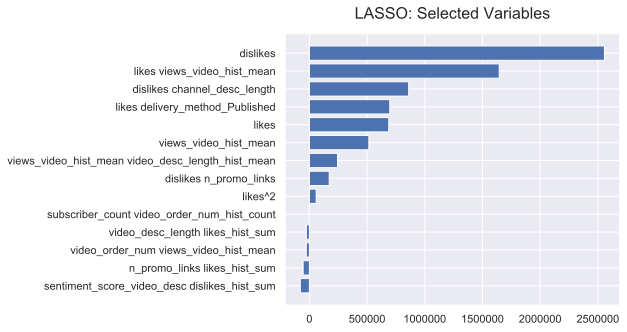

In [389]:
plt.figure(figsize=[6,5])
plt.barh(df_coefs_non_zero['variable'], width = df_coefs_non_zero['coefficient'])
plt.title('LASSO: Selected Variables', fontsize=16, pad=15)
#plt.legend(loc='lower left', labels = ['Train', 'Test'])
#plt.savefig('R2_f', format = 'svg')
cor.sort_values(['views_video'], 
                          inplace=True, ascending=True)

## Model2: Remove variables that we do not have for new video

Inspect

In [83]:
df_nolidisl = df.drop(['likes', 'dislikes','channel_URL', 'channel_name'], axis=1)

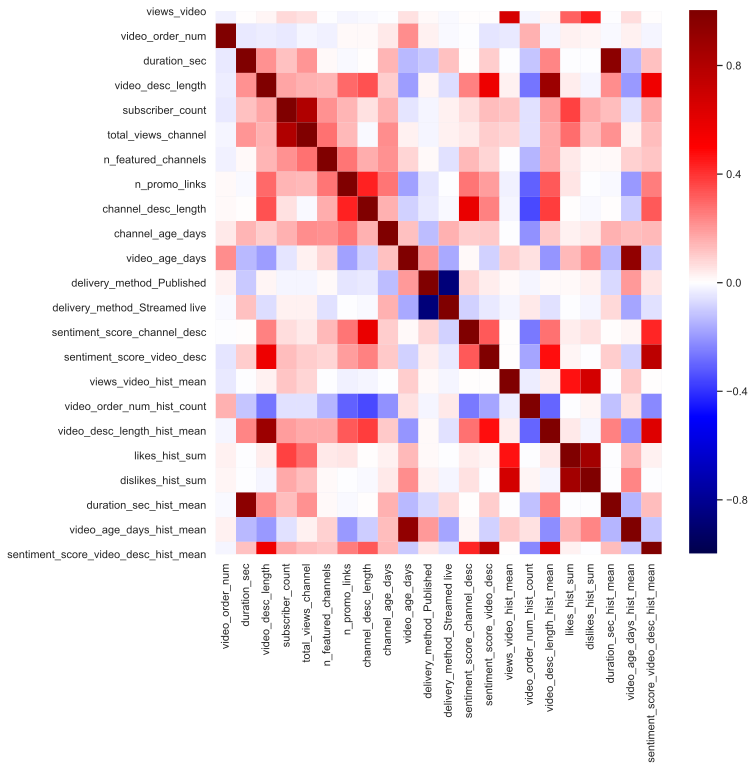

In [220]:
plt.figure(figsize=[10,10])
sns.heatmap(df_nolidisl.corr(), square=False, cmap="seismic", annot=False,  vmin=-1, vmax=1)
plt.gca().set_xlim(1);

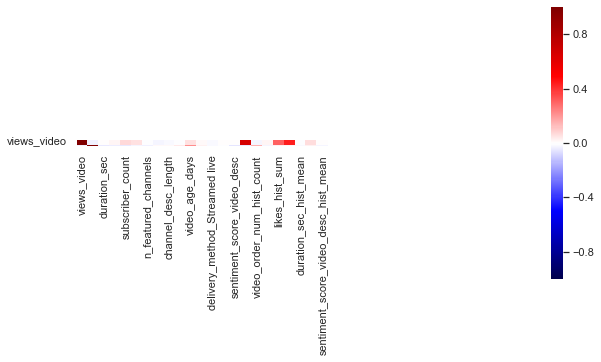

In [86]:
plt.figure(figsize=[10,10])
sns.heatmap(df_nolidisl.corr(), 
            cmap="seismic", annot=False,  vmin=-1, vmax=1, square=True, 
            cbar_kws = dict(orientation = 'vertical', shrink =0.5, pad =0.4, aspect=22))
#ax_divider
#plt.gca().set_ylim(len(df_no_outliers_history_nolidisl.corr())+0.5, -0.5);
plt.gca().set_ylim(1);
#plt.gca().set_xlim(1);

Model

In [87]:
#removing likes and dislikes
X_array_h_rem_likes = df.loc[:,['video_order_num', 'duration_sec', 
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc',
       'views_video_hist_mean', 'video_order_num_hist_count',
       'video_desc_length_hist_mean', 'likes_hist_sum', 'dislikes_hist_sum',
       'duration_sec_hist_mean', 'video_age_days_hist_mean',
       'sentiment_score_video_desc_hist_mean']].values.reshape(-1, 1)

X_df_h_rem_likes = df[['video_order_num', 'duration_sec', 
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc',
       'views_video_hist_mean', 'video_order_num_hist_count',
       'video_desc_length_hist_mean', 'likes_hist_sum', 'dislikes_hist_sum',
       'duration_sec_hist_mean', 'video_age_days_hist_mean',
       'sentiment_score_video_desc_hist_mean']]

y_h_rem_likes = df['views_video']

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X_df_h_rem_likes, y_h_rem_likes, 
                                                    test_size=0.3, 
                                                    random_state=42)

vanilla_LR_rl = LinearRegression()
vanilla_LR_rl.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [117]:
vanilla_LR_rl.score(X_train,y_train) 

0.47071838197885274

In [118]:
vanilla_LR_rl.score(X_test,y_test)

-0.5545173252566922

In [120]:
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
X_te = std.transform(X_test)#numpy.ndarray

In [141]:
alphavec = 10**np.linspace(-6,4,200)
lasso_model_rl = LassoCV(alphas = alphavec, cv=5)
lasso_model_rl.fit(X_tr, y_train);

In [142]:
lasso_model_rl.score(X_tr,y_train)

0.4703677315816639

In [143]:
lasso_model_rl.alpha_

10000.0

In [144]:
lasso_model_rl.score(X_te,y_test) ##doesnt work as it is about variation in the data, 

-0.5137389688002472

In [115]:
scores_full = {'baseline':[0.9597382729266982, 0.7475116440993992], 'baseline-lasso':[0.9596720678574545, 0.7487661708655377], 'added-features':[0.9965608803465577, -2.2976078488820093], 'added-features-lasso': [0.9892881419367454, 0.7735661621041386] }

In [149]:
scores_no_likes = {'baseline':[0.47071838197885274, -0.5545173252566922], 'baseline-lasso':[0.4703677315816639, -0.5137389688002472], 'added-features':[0.671638781800988, -9.499030390134314], 'added-features-lasso': [0.46571963880441947, -0.5137389688002472] }

In [168]:
scores_full_df = pd.DataFrame.from_dict(scores_full).T.reset_index()

In [171]:
scores_full_df.rename(columns={0:'R2_train', 1:'R2_test', 'index':'model'}, inplace=True)

In [172]:
scores_full_df.head()

,model,R2_train,R2_test
0,baseline,0.959738,0.747512
1,baseline-lasso,0.959672,0.748766
2,added-features,0.996561,-2.297608
3,added-features-lasso,0.989288,0.773566


In [173]:
scores_no_likes_df = pd.DataFrame.from_dict(scores_no_likes).T.reset_index()

In [174]:
scores_no_likes_df.rename(columns={0:'R2_train', 1:'R2_test', 'index':'model'}, inplace=True)

In [175]:
scores_no_likes_df.head()

,model,R2_train,R2_test
0,baseline,0.470718,-0.554517
1,baseline-lasso,0.470368,-0.513739
2,added-features,0.671639,-9.499030
3,added-features-lasso,0.465720,-0.513739


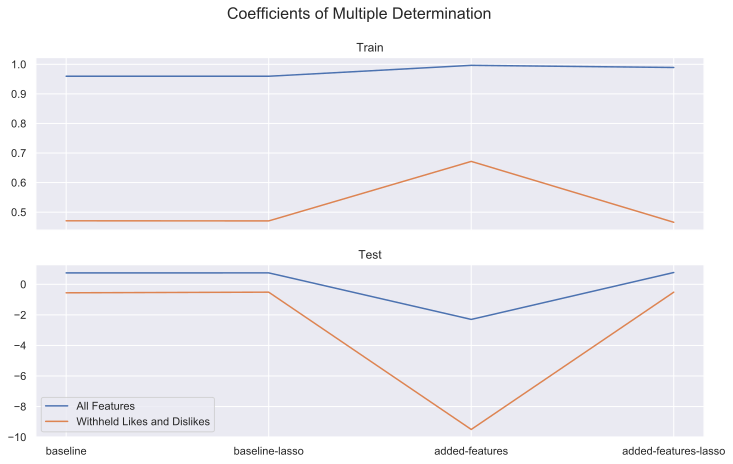

In [197]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=False, figsize=[12,7])
plt.suptitle('Coefficients of Multiple Determination', fontsize=16)

#Col1

ax[0].plot(scores_full_df['model'], scores_full_df['R2_train'])
ax[0].plot(scores_no_likes_df['model'], scores_no_likes_df['R2_train'])
ax[0].set_title('Train')

#Col2

ax[1].plot(scores_full_df['model'], scores_full_df['R2_test'])
ax[1].plot(scores_no_likes_df['model'], scores_no_likes_df['R2_test'])
ax[1].legend(loc='lower left', labels = ['All Features', 'Withheld Likes and Dislikes'])
ax[1].set_title('Test');
plt.savefig('R2')

In [203]:
f = scores_full_df[scores_full_df['R2_test']>0]

In [201]:
c = scores_no_likes_df[scores_no_likes_df['R2_test']>0]
c

,model,R2_train,R2_test


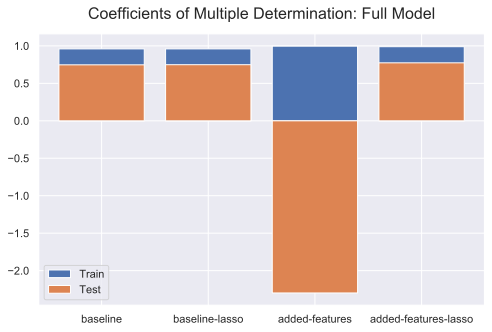

In [217]:
plt.figure(figsize=[8,5])
plt.bar(scores_full_df['model'], height = scores_full_df['R2_train'])
plt.bar(scores_full_df['model'], height = scores_full_df['R2_test'])
plt.title('Coefficients of Multiple Determination: Full Model', fontsize=16, pad=15)
plt.legend(loc='lower left', labels = ['Train', 'Test'])
plt.savefig('R2_f', format = 'svg')

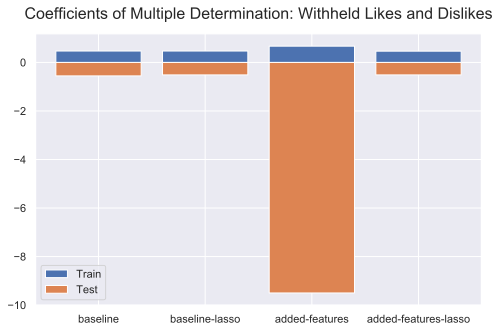

In [218]:
plt.figure(figsize=[8,5])
plt.bar(scores_no_likes_df['model'], height = scores_no_likes_df['R2_train'])
plt.bar(scores_no_likes_df['model'], height = scores_no_likes_df['R2_test'])
plt.title('Coefficients of Multiple Determination: Withheld Likes and Dislikes', fontsize=16, pad=15)
plt.legend(loc='lower left', labels = ['Train', 'Test'])
plt.savefig('R2_c')

In [262]:
cor = df.corr().iloc[0].reset_index()

In [263]:
cor

,index,views_video
0,views_video,1.000000
1,video_order_num,-0.030365
2,duration_sec,0.002334
3,likes,0.927656
4,dislikes,0.939958
5,video_desc_length,0.017946
6,subscriber_count,0.072211
7,total_views_channel,0.055031
8,n_featured_channels,-0.002342
9,n_promo_links,-0.017031


In [264]:
cor['views_video'] = round(cor['views_video'], 2)

In [265]:
cor = cor.iloc[1:,:]

In [266]:
cor = cor.iloc[:-1,:]

In [276]:
cor.sort_values(['views_video'], 
                          inplace=True, ascending=True)

In [283]:
cor['positive'] = cor['views_video']>0

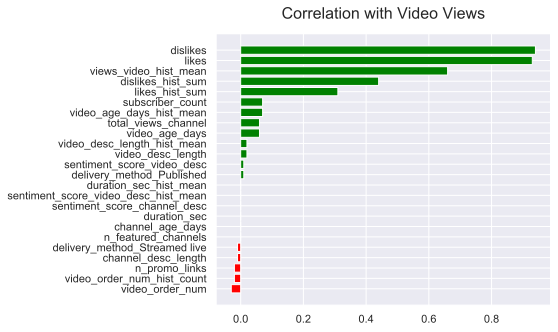

In [391]:
plt.figure(figsize=[6,5])
plt.barh(cor['index'], width = cor['views_video'], color=cor.positive.map({True:'green', False:'red'}))
#plt.barh(df_coefs_non_zero['variable'], width = df_coefs_non_zero['coefficient'])
#plt.barh(cor['index'], width = cor['views_video'])
plt.title('Correlation with Video Views', fontsize=16, pad=15)
plt.savefig('R2_c')

In [ ]:
df_weekdays.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)

Conclusion: one cannot predict views without likes/dislikes or other features. 